# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Configuration

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.device_count())

DEVICE = torch.device('cpu')
#DEVICE = torch.device('cuda:0')
ROLLOUT_LENGTH = 250 
DISCOUNT = 0.99
GAE_LAMBDA = 0.95
OPTIMIZATION_EPOCHS = 10
MINI_BATCH_SIZE = 64
PPO_RATIO_CLIP = 0.1
GRADIENT_CLIP = 0.75
HIDDEN_LAYERS = 32

cpu
False
1.10.0+cpu
0


### Third-party Code
These are helper routines copied or adapted from other projects.

In [6]:
# Thank you for these helper routines to Shangtong Zhang 
# https://github.com/ShangtongZhang/DeepRL

def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

def to_np(t):
    return t.cpu().detach().numpy()

def tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    x = torch.tensor(x, device=DEVICE, dtype=torch.float32)
    return x

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

class MeanStdNormalizer():
    def __init__(self):
        self.rms = None
        self.clip = 10.0
        self.epsilon = 1e-8

    def __call__(self, x):
        x = np.asarray(x)
        if self.rms is None:
            self.rms = RunningMeanStd(shape=(1, ) + x.shape[1:])
        self.rms.update(x)
        return np.clip((x - self.rms.mean) / np.sqrt(self.rms.var + self.epsilon),
                       -self.clip, self.clip)    


In [7]:
# Thank you for these helper routines to OpenAI.

# https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py    
class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)    
        
def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count
                

### The Master Agent

The master agent implements the PPO algorithm and can use multiple sub-agents for the purpose of samlping trajectories.

In [8]:
import random
from collections import namedtuple, deque

class SubNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_units, output_size, seed):
        super(SubNetwork, self).__init__()
        dims = (input_size,) + hidden_units        
        self.layers = nn.ModuleList([layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.feature_dim = dims[-1]
        self.output_layer = layer_init(nn.Linear(self.feature_dim, output_size), 1e-3)
        
    def forward(self, x):
        for layer in self.layers:
            x = F.tanh(layer(x))
        x = self.output_layer(x)    
        return x    
            
class ActorAndCritic(nn.Module):
    
    def __init__(self, num_agents, state_size, action_size, seed):
        super(ActorAndCritic, self).__init__()
        self.seed = random.seed(seed)
        self.actor = SubNetwork(state_size, (HIDDEN_LAYERS, HIDDEN_LAYERS), action_size, seed)
        self.critic = SubNetwork(state_size, (HIDDEN_LAYERS, HIDDEN_LAYERS), 1, seed)
        self.std = nn.Parameter(torch.zeros(action_size))
        #self.to(Config.DEVICE)
        
    def forward(self, obs, action=None):
        obs = tensor(obs)
        a = self.actor(obs)
        v = self.critic(obs)
        mean = F.tanh(a)
        dist = torch.distributions.Normal(mean, F.softplus(self.std))
        return (v, dist)
        
class Rollout():
    
    def __init__(self):
        # Stored values
        self.actions = []
        self.log_prob_actions = []
        self.values = []
        self.rewards = []
        self.episode_not_dones = []
        self.states = []
        # Calculated values
        self.returns = [0.0] * ROLLOUT_LENGTH
        self.advantages = [0.0] * ROLLOUT_LENGTH
        
    def save_prediction(self, actions, log_prob_actions, values):
        self.actions.append(actions)
        self.log_prob_actions.append(log_prob_actions)
        self.values.append(values)

    def save_consequences(self, rewards, episode_not_dones, states):
        self.rewards.append(rewards)
        self.episode_not_dones.append(episode_not_dones)
        self.states.append(states)
        
    def calculate_returns_and_advantages(self, final_reward):
        self.rewards.append(None)
        self.episode_not_dones.append(None)
        self.calculate_future_returns(final_reward)
        self.estimate_advantages()

    def calculate_future_returns(self, returns):
        for i in reversed(range(ROLLOUT_LENGTH)):
            returns = self.rewards[i] + DISCOUNT * self.episode_not_dones[i] * returns
            self.returns[i] = returns.detach() 

    def estimate_advantages(self):
        advantages = tensor(np.zeros((num_agents, 1)))
        # Go backwards through rollout steps and calculate advantages for each state action pair
        # Use GAE for PPO. (Schulman, Moritz, Levine et al. 2016)
        for i in reversed(range(ROLLOUT_LENGTH)):
            td = self.rewards[i] + (DISCOUNT * self.episode_not_dones[i] * self.values[i + 1]) - self.values[i]
            advantages = advantages * GAE_LAMBDA * DISCOUNT * self.episode_not_dones[i] + td
            self.advantages[i] = advantages.detach()               

    def stack_tensor(self, some_list):
        return torch.cat(some_list[:ROLLOUT_LENGTH], dim=0)
            
    def get_sample_data(self):
        states = self.stack_tensor(self.states)
        actions = self.stack_tensor(self.actions) 
        log_prob_actions = self.stack_tensor(self.log_prob_actions)
        returns = self.stack_tensor(self.returns)
        # Normalize advantages
        advantages = self.stack_tensor(self.advantages)
        advantages = (advantages - advantages.mean()) / advantages.std()        
        return (states, actions, log_prob_actions, returns, advantages)
    
class MasterAgent():   
    
    def __init__(self, num_agents, state_size, action_size, seed):
        self.network = ActorAndCritic(num_agents, state_size, action_size, seed)
        self.first_states = True
        self.total_steps = 0
        self.state_normalizer = MeanStdNormalizer()
        
    def evaluate_actions_against_states(self, states, actions):
        value, action_distribution = self.network(states, actions)
        log_prob = self.get_log_prob(action_distribution, actions)
        return (log_prob, value)
    
    def get_log_prob(self, action_distribution, actions):
        return action_distribution.log_prob(actions).sum(-1).unsqueeze(-1)
    
    def get_prediction(self, states):
        if self.first_states:
            self.states = states
            self.first_states = False
        #self.latest_actions, self.latest_log_prob, self.latest_values = self.get_prediction_from_states(self.states)
        self.latest_values, action_distribution = self.network(self.states)
        self.latest_actions = action_distribution.sample()
        self.latest_log_prob = self.get_log_prob(action_distribution, self.latest_actions)
        return self.latest_actions
    
    def step(self, states, actions, rewards, next_states, dones):
        rewards = np.asarray(rewards)
        next_states = self.state_normalizer(next_states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
        dones = np.asarray(dones).astype(int)
        rewards = tensor(rewards).unsqueeze(-1)
        episode_not_dones = tensor(1 - dones).unsqueeze(-1)
        states = tensor(self.states)        
        self.rollout.save_consequences(rewards, episode_not_dones, states)

        self.states = next_states
                
    def start_rollout(self):
        self.rollout = Rollout()
            
    def process_rollout(self, states):
        self.save_final_results(states)
        self.rollout.calculate_returns_and_advantages(self.latest_values.detach())
        self.optimize()
        self.first_states = True
        
    def save_final_results(self, states):    
        self.get_prediction(states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
   
    def save_weights(self):
        print("======== Saving weights ==========")
        torch.save(self.network.state_dict(), "trained_weights.pth")

    def optimize(self):
        # Now use tensors for 's', 'a', 'log_pi_a', 'ret', 'adv' for training
        # states, actions, log prob actions, returns, advantages (1 row / timestep, 1 column per worker)

        states, actions, log_probs_old, returns, advantages = self.rollout.get_sample_data()
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        optimizer = torch.optim.Adam(self.network.parameters(), 3e-4, eps=1e-5)
        for i in range(OPTIMIZATION_EPOCHS):
            number_timesteps = states.size(0)
            timesteps_to_sample = random_sample(np.arange(number_timesteps), MINI_BATCH_SIZE) 
            for timestep in timesteps_to_sample:
                t = tensor(timestep).long()
                # Get data for all workers from sampled timestep 
                sampled_states = states[t]
                sampled_actions = actions[t]
                sampled_log_probs_old = log_probs_old[t]
                sampled_returns = returns[t]
                sampled_advantages = advantages[t]
                self.optimize_with_sampled_worker_data(optimizer, sampled_states,
                                                                  sampled_actions,
                                                                  sampled_log_probs_old,
                                                                  sampled_returns,
                                                                  sampled_advantages)
        steps = ROLLOUT_LENGTH * num_agents
        # Total steps used to train network
        self.total_steps += steps
        
    def optimize_with_sampled_worker_data(self, optimizer, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages):
        # Get log_prob(actions) and value given states
        # Pass in states for all workers x batch_size.
        log_prob_action, value = self.evaluate_actions_against_states(sampled_states, sampled_actions)
        
        policy_loss = self.get_policy_loss(log_prob_action, sampled_log_probs_old, sampled_advantages)
        value_loss = self.get_value_loss(value, sampled_returns)
        
        # Do the actual optimization
        optimizer.zero_grad()
        # Overall loss function for training both networks at once. Get gradients on weights.
        (policy_loss + value_loss).backward()
        # Clip weight gradients 
        nn.utils.clip_grad_norm_(self.network.parameters(), GRADIENT_CLIP) 
        # Run actual optimization
        optimizer.step()
        
    def get_policy_loss(self, log_prob_action, sampled_log_probs_old, sampled_advantages):
        # This is the core of PPO
        # ratio = new prob / old prob for all workers
        ratio = (log_prob_action - sampled_log_probs_old).exp() 
        # Clip loss on the upside
        clamped_ratio = ratio.clamp(1.0 - PPO_RATIO_CLIP, 1.0 + PPO_RATIO_CLIP)
        obj = ratio * sampled_advantages
        obj_clipped = clamped_ratio * sampled_advantages
        policy_loss = -torch.min(obj, obj_clipped).mean() 
        return policy_loss
    
    def get_value_loss(self, value, sampled_returns):
        # Mean squared error
        value_loss = 0.5 * (sampled_returns - value).pow(2).mean()
        return value_loss


### Training

The TrainingSession class trains the agent while monitoring the progress of the episodes. It can also simply run an episode with the previously trained policy.

In [9]:
class TrainingSession():
    
    def __init__(self, num_workers):
        self.num_workers = num_workers
        self.online_rewards = np.zeros(num_workers)
        self.mean_last_100 = 0
        self.mean_scores = []

    def train_ppo(self, agent, target_average_score, max_episodes=300):
        print("Attempting to reach 100 episode trailing average of {:.2f} in under {} episodes.".format(target_average_score, max_episodes))
        print("Rollout length: %s" % ROLLOUT_LENGTH)
        print("GRADIENT_CLIP %s" % GRADIENT_CLIP)
        print("PPO_RATIO_CLIP %s" % PPO_RATIO_CLIP)
        print("GAE_LAMBDA %s" % GAE_LAMBDA)
        #agent.save_weights()
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment   
        self.num_episodes = 0
        self.last_100_scores = deque(maxlen=100)
        self.episode_scores = [list() for i in range(num_agents)]
        self.episodes_finished = 0
        self.target_average_score = target_average_score
        while True:
            mean_last_100 = self.run_rollout(agent, env_info)
            agent.process_rollout(states)
            
            #print("\rEpisode {}\tLast 100: {:.2f}".format(self.num_episodes, mean_last_100))
            if mean_last_100 > target_average_score:
                print("Reached target! mean_last_100 %s" % mean_last_100)
                agent.save_weights() 
                break
            if self.num_episodes > max_episodes:
                print("Failed to reach target in {} episodes.".format(self.num_episodes))
                break
        return self.mean_scores 
    
    def get_actions_from_policy(self, states):
        actions = agent.get_prediction(states)          # Run the policy 
        actions = to_np(actions)                        # Extract actions
        actions = np.clip(actions, -1, 1)               # all actions between -1 and 1
        return actions
    
    def run_ppo(self, agent, max_episodes=5):
        env_info = env.reset(train_mode=False)[brain_name]
        self.last_100_scores = deque(maxlen=100)
        self.num_episodes = 0
        while True:
            mean_score_over_agents = self.run_rollout(agent, env_info)
            self.num_episodes += 1
            if self.num_episodes > max_episodes:
                print("Policy failed to reach target in %s" % max_episodes)
                break
    
    def step_environment(self, env, actions):
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment        
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished for each agent
        return (next_states, rewards, dones)
                                
    def run_episode(self, env_info):
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.start_rollout()
        while True:
            actions = self.get_actions_from_policy(states)
            next_states, rewards, dones = self.step_environment(env, actions)
            
    def run_rollout(self, agent, env_info):
        #print("Run rollout")
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.start_rollout()
        for t in range(ROLLOUT_LENGTH):
            actions = self.get_actions_from_policy(states)            
            next_states, rewards, dones = self.step_environment(env, actions)
        
            # Save rewards
            self.online_rewards += rewards                          # Accumulate ongoing (un-normalized) rewards for each agent
            for i, done in enumerate(dones):
                if done:                                       # For a worker whose episode is done...
                    #print("Worker %s finished at timestep %s" % (i, t))
                    self.end_episode(i, self.online_rewards[i])
                    self.online_rewards[i] = 0                 # Reset accumulated reward for next episode
                    self.mean_last_100 = np.mean(self.last_100_scores)
                    if self.mean_last_100 > self.target_average_score:
                        print("Breaking")
                        break
            #print("%s step" % t)            
            agent.step(states, actions, rewards, next_states, dones) # Teach the agent 
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step

        #print("Steps in rollout: {}".format(t+1))        
        return self.mean_last_100    

    def end_episode(self, agent_index, score):
        self.episode_scores[agent_index].append(score)   # Save the reward they accumulated in the episode
        self.episodes_finished +=1
        if (self.episodes_finished % num_agents) == 0:
            self.num_episodes += 1
            total_over_agents = 0
            for i in range(num_agents):
                total_over_agents += self.episode_scores[i][-1]
            mean_score_over_agents = total_over_agents / num_agents    
            self.last_100_scores.append(mean_score_over_agents)
            self.mean_scores.append(mean_score_over_agents)
            print("Finished %s episodes (%s cycles). mean_score_over_agents %s trailing %s" % (self.num_episodes, (self.episodes_finished/num_agents), mean_score_over_agents, np.mean(self.last_100_scores)))


### Train the Policy

Running the code in the cell below trains the policy, attempting to reach the target treailing avewrage value.

Attempting to reach 100 episode trailing average of 0.20 in under 300 episodes.
Rollout length: 250
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95


C:\ProgramData\anaconda3\envs\drlnd2\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\ProgramData\anaconda3\envs\drlnd2\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\anaconda3\envs\drlnd2\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished 1 episodes (1.0 cycles). mean_score_over_agents 0.24249999457970262 trailing 0.24249999457970262
Breaking
Reached target! mean_last_100 0.24249999457970262
======== Saving weights ==========
Training run time：8.028068s


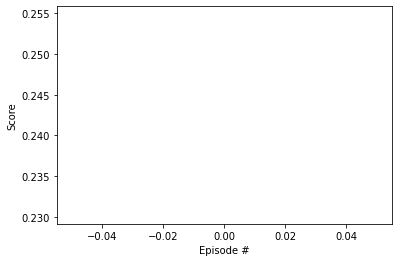

In [20]:
agent = MasterAgent(num_agents, state_size=state_size, action_size=action_size, seed=0)
import time
session = TrainingSession(num_agents)
start_time = time.time()
scores = session.train_ppo(agent, 0.20)   # Do the training
run_time = time.time() - start_time

import matplotlib.pyplot as plt
%matplotlib inline
 

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

print("Training run time：{:.6f}s".format(run_time))



### Run the Policy
The code below runs the policy that has previously been trained.

In [15]:
session.run_ppo(agent) 

C:\ProgramData\anaconda3\envs\drlnd2\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\ProgramData\anaconda3\envs\drlnd2\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\anaconda3\envs\drlnd2\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished 5 episodes (149.0 cycles). mean_score_over_agents 37.74299915637821 trailing 37.74299915637821
Breaking
Policy failed to reach target in 5


In [ ]:
env.close()